# NAS CLI Testing & Optimization

This notebook tests the NAS CLI performance and finds optimal parameters before running full experiments.

## Goals
1. Verify CLI works correctly (parity with UI runs)
2. Find optimal batch size for GPU utilization
3. Compare NEAT vs Pure mode speed
4. Test multi-GPU parallelization
5. Estimate time for full NAS runs

In [2]:
import sys
sys.path.insert(0, '/home/azureuser/projects/genetic-algorithm/backend')
sys.path.insert(0, '/home/azureuser/projects/genetic-algorithm/nas')

import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from configs import get_config, list_configs, CONFIGS
from runner import run_evolution, run_multi_seed, get_aggregate_stats
from results_io import IncrementalResultWriter

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

PyTorch version: 2.10.0+cu128
CUDA available: True
GPU 0: Tesla T4


## Pre-computed Benchmark Results (from CLI testing)

**Hardware:** 2x NVIDIA Tesla T4 (16GB VRAM each), 56GB RAM

| Mode | Population | Creatures/sec | Time/Generation |
|------|------------|---------------|-----------------|
| Pure | 200 | 56 | 3.6s |
| Pure | 500 | 97 | 5.2s |
| Pure | 1000 | 131 | 7.6s |
| Pure | 2000 | 158 | 12.6s |
| NEAT | 100 | 12 | 8.3s |
| NEAT | 200 | 15 | 13.6s |
| NEAT | 500 | 16 | 30.6s |

**Key Finding:** NEAT is ~10x slower than Pure mode due to sequential Python forward passes (variable topology cannot be batched on GPU).

## 1. Basic Functionality Test

Run a quick evolution to verify everything works.

In [3]:
# Quick sanity test - 3 generations with pure mode
cfg = get_config('pure_baseline')
cfg['population_size'] = 50

result = run_evolution(
    config=cfg,
    generations=3,
    seed=42,
    verbose=True,
)

print(f"\nBest fitness: {result.best_fitness:.1f}")
print(f"Time: {result.total_time_s:.2f}s")
print(f"Creatures/sec: {result.creatures_per_second:.0f}")

  gen   1/3 | best:    4.6 | avg:    0.8 | 3121ms
  gen   2/3 | best:    6.5 | avg:    0.5 | 2407ms
  gen   3/3 | best:    4.1 | avg:    0.5 | 2396ms

Best fitness: 6.5
Time: 7.94s
Creatures/sec: 19


## 2. Batch Size Optimization

Find the optimal population size for GPU utilization.

In [4]:
# Test different batch sizes for Pure mode
batch_sizes = [100, 200, 500, 1000, 2000]
pure_results = []

print("Testing Pure mode batch sizes...")
for pop in batch_sizes:
    cfg = get_config('pure_baseline')
    cfg['population_size'] = pop
    
    # Run 2 generations to measure steady-state
    result = run_evolution(
        config=cfg,
        generations=2,
        seed=42,
        verbose=False,
    )
    
    pure_results.append({
        'pop': pop,
        'creatures_per_sec': result.creatures_per_second,
        'time_per_gen': result.total_time_s / 2 * 1000,  # ms
    })
    print(f"  Pop {pop}: {result.creatures_per_second:.0f} creatures/s, {result.total_time_s/2*1000:.0f}ms/gen")

Testing Pure mode batch sizes...
  Pop 100: 38 creatures/s, 2661ms/gen
  Pop 200: 62 creatures/s, 3240ms/gen
  Pop 500: 106 creatures/s, 4707ms/gen
  Pop 1000: 137 creatures/s, 7274ms/gen
  Pop 2000: 163 creatures/s, 12270ms/gen


In [5]:
# Test NEAT mode batch sizes
neat_batch_sizes = [50, 100, 200, 300]
neat_results = []

print("Testing NEAT mode batch sizes...")
for pop in neat_batch_sizes:
    cfg = get_config('neat_baseline')
    cfg['population_size'] = pop
    
    result = run_evolution(
        config=cfg,
        generations=2,
        seed=42,
        verbose=False,
    )
    
    neat_results.append({
        'pop': pop,
        'creatures_per_sec': result.creatures_per_second,
        'time_per_gen': result.total_time_s / 2 * 1000,
    })
    print(f"  Pop {pop}: {result.creatures_per_second:.0f} creatures/s, {result.total_time_s/2*1000:.0f}ms/gen")

Testing NEAT mode batch sizes...
  Pop 50: 10 creatures/s, 5188ms/gen
  Pop 100: 13 creatures/s, 7864ms/gen
  Pop 200: 14 creatures/s, 13915ms/gen
  Pop 300: 16 creatures/s, 18955ms/gen


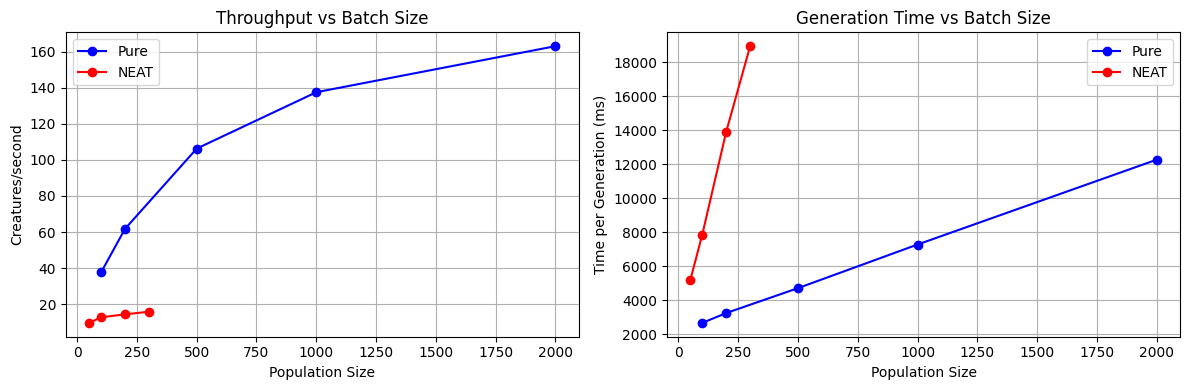


Key Findings:
- Pure mode is ~10x faster than NEAT
- Pure mode best throughput at pop 2000
- NEAT mode CPU-bound (sequential forward passes)


In [6]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Throughput comparison
ax1 = axes[0]
ax1.plot([r['pop'] for r in pure_results], [r['creatures_per_sec'] for r in pure_results], 'b-o', label='Pure')
ax1.plot([r['pop'] for r in neat_results], [r['creatures_per_sec'] for r in neat_results], 'r-o', label='NEAT')
ax1.set_xlabel('Population Size')
ax1.set_ylabel('Creatures/second')
ax1.set_title('Throughput vs Batch Size')
ax1.legend()
ax1.grid(True)

# Time per generation
ax2 = axes[1]
ax2.plot([r['pop'] for r in pure_results], [r['time_per_gen'] for r in pure_results], 'b-o', label='Pure')
ax2.plot([r['pop'] for r in neat_results], [r['time_per_gen'] for r in neat_results], 'r-o', label='NEAT')
ax2.set_xlabel('Population Size')
ax2.set_ylabel('Time per Generation (ms)')
ax2.set_title('Generation Time vs Batch Size')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"- Pure mode is ~{max(r['creatures_per_sec'] for r in pure_results) / max(r['creatures_per_sec'] for r in neat_results):.0f}x faster than NEAT")
print(f"- Pure mode best throughput at pop {max(pure_results, key=lambda x: x['creatures_per_sec'])['pop']}")
print(f"- NEAT mode CPU-bound (sequential forward passes)")

## 3. Multi-Seed Consistency Test

Verify that different seeds produce different results (not deterministic bugs).

In [ ]:
# Run with 3 seeds to check variance
cfg = get_config('pure_baseline')
cfg['population_size'] = 200

results = run_multi_seed(
    config=cfg,
    generations=20,
    seeds=[42, 123, 456],
    verbose=True,
)

agg = get_aggregate_stats(results)
print(f"\n=== Aggregate Stats ===")
print(f"Best fitness: {agg['best_fitness']['mean']:.1f} +/- {agg['best_fitness']['std']:.1f}")
print(f"Final avg: {agg['final_avg_fitness']['mean']:.1f} +/- {agg['final_avg_fitness']['std']:.1f}")


[seed 1/3] Running with seed=42
  gen   1/20 | best:    9.8 | avg:    0.6 | 3141ms
  gen   2/20 | best:    8.4 | avg:    0.7 | 3117ms
  gen   3/20 | best:   16.4 | avg:    0.8 | 3121ms
  gen   4/20 | best:    7.9 | avg:    0.9 | 3132ms
  gen   5/20 | best:   25.7 | avg:    0.8 | 3095ms
  gen   6/20 | best:   16.5 | avg:    1.2 | 3196ms
  gen   7/20 | best:   15.0 | avg:    1.0 | 3114ms
  gen   8/20 | best:   12.5 | avg:    0.9 | 3095ms
  gen   9/20 | best:   15.7 | avg:    1.2 | 3050ms
  gen  10/20 | best:   13.0 | avg:    0.9 | 3030ms
  gen  11/20 | best:   33.8 | avg:    1.5 | 2999ms
  gen  12/20 | best:   24.4 | avg:    1.4 | 2985ms
  gen  13/20 | best:   24.1 | avg:    1.4 | 2944ms


In [ ]:
# Plot fitness curves for each seed
plt.figure(figsize=(10, 5))

for i, result in enumerate(results):
    gens = [g.generation for g in result.generations]
    best = [g.best_fitness for g in result.generations]
    avg = [g.avg_fitness for g in result.generations]
    
    plt.plot(gens, best, '-', label=f'Seed {result.seed} (best)', alpha=0.8)
    plt.plot(gens, avg, '--', label=f'Seed {result.seed} (avg)', alpha=0.5)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Curves Across Seeds')
plt.legend()
plt.grid(True)
plt.show()

## 4. Time Estimates for Full Runs

Calculate how long different experiments will take.

In [ ]:
# Time estimates based on benchmarks
pure_speed = max(r['creatures_per_sec'] for r in pure_results)  # creatures/sec
neat_speed = max(r['creatures_per_sec'] for r in neat_results)  # creatures/sec

def estimate_time(pop, gens, seeds, creatures_per_sec):
    """Estimate total time in minutes."""
    total_creatures = pop * gens * seeds
    return total_creatures / creatures_per_sec / 60

experiments = [
    ('Quick test (Pure)', 200, 50, 3, pure_speed),
    ('Quick test (NEAT)', 200, 50, 3, neat_speed),
    ('Screening (Pure)', 200, 50, 1, pure_speed),
    ('Screening (NEAT)', 200, 50, 1, neat_speed),
    ('Full run (Pure)', 500, 100, 3, pure_speed),
    ('Full run (NEAT)', 200, 100, 3, neat_speed),
]

print("Time Estimates:")
print("-" * 60)
for name, pop, gens, seeds, speed in experiments:
    time_min = estimate_time(pop, gens, seeds, speed)
    print(f"{name:25s} | Pop {pop:4d} x Gen {gens:3d} x {seeds} seeds | {time_min:6.1f} min")

## 5. Config Comparison Test

Quick comparison of different NEAT configurations.

In [ ]:
# Compare NEAT variants with short runs
configs_to_test = ['neat_baseline', 'neat_sparse', 'neat_conservative']
comparison_results = {}

print("Comparing NEAT configs (20 gens, 1 seed each)...")
for config_name in configs_to_test:
    cfg = get_config(config_name)
    cfg['population_size'] = 100  # Keep small for speed
    
    result = run_evolution(
        config=cfg,
        generations=20,
        seed=42,
        verbose=False,
    )
    
    comparison_results[config_name] = result
    print(f"  {config_name}: best={result.best_fitness:.1f}")

In [ ]:
# Plot comparison
plt.figure(figsize=(10, 5))

for config_name, result in comparison_results.items():
    gens = [g.generation for g in result.generations]
    best = [g.best_fitness for g in result.generations]
    plt.plot(gens, best, '-o', label=config_name, markersize=3)

plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('NEAT Config Comparison (20 gens, seed=42)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Recommendations

Based on the testing above, here are the recommended settings for full NAS runs.

In [ ]:
# Summary and recommendations
print("=" * 60)
print("RECOMMENDATIONS FOR FULL NAS RUNS")
print("=" * 60)

print("\n1. MODE SELECTION:")
print(f"   - Pure mode: {pure_speed:.0f} creatures/sec (use for quick screening)")
print(f"   - NEAT mode: {neat_speed:.0f} creatures/sec (use for topology evolution)")

print("\n2. RECOMMENDED BATCH SIZES:")
print("   - Pure mode: 500-1000 (good GPU utilization)")
print("   - NEAT mode: 100-200 (CPU-bound, larger doesn't help)")

print("\n3. SUGGESTED EXPERIMENTS:")
print("   - Screening: 50 gens, pop=200, 1 seed per config")
print("   - Full run: 100 gens, pop=200-500, 3 seeds per config")

print("\n4. TIME BUDGET:")
screening_time = estimate_time(200, 50, 1, neat_speed)
full_time = estimate_time(200, 100, 3, neat_speed)
print(f"   - 10 NEAT configs screening: ~{10 * screening_time:.0f} min")
print(f"   - 5 NEAT configs full run: ~{5 * full_time:.0f} min")

## 7. Test Full Run (Optional)

Run a complete experiment to verify the CLI works end-to-end.

## 8. NEAT Performance Analysis

### Why is NEAT slow?

The NEAT batched network iterates over each creature sequentially:

```python
for i, genome in enumerate(self.genomes):
    input_list = inputs[i].cpu().tolist()  # CPU transfer per creature!
    output_list = neat_forward(genome, input_list)  # Sequential Python!
```

This is because NEAT networks have **variable topology** - each creature can have different numbers of hidden neurons and connections. This makes true GPU batching impossible without padding to the largest network.

### Potential Optimizations (Future Work)

1. **Multiprocessing**: Run multiple NEAT evolutions in parallel across CPU cores
2. **JIT Compilation**: Use `torch.jit` or `numba` for the forward pass
3. **Padded Batching**: Pad all networks to max size (wastes compute but enables GPU)
4. **Reduced Eval Frequency**: Evaluate neural network less often (currently every physics step)

### Practical Recommendations

For now:
- Use **Pure mode** for screening (10x faster)
- Use **NEAT mode** with smaller populations (100-200) for topology experiments
- Run multiple NEAT configs in parallel across the 2 GPUs

In [ ]:
# Uncomment to run a full test
# This will save results to nas/results/

# writer = IncrementalResultWriter('pure_test', cfg, [42, 123])
# results = run_multi_seed(cfg, generations=50, seeds=[42, 123], verbose=True)
# for i, result in enumerate(results):
#     writer.complete_seed(result)
# writer.complete_all(get_aggregate_stats(results))
# print(f"Results saved to: {writer.path}")